In [1]:
import sys

PWD = '../..'
sys.path.append(PWD)

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import norm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from src.plot_utils import plot_sample, plot_history
from src.cfd import CFD
from src.cfd_utils import TIME_STEP, plot_diff_hist_stats, _get_gauss_stats

In [2]:
dataset = np.load(PWD + f'/data/dataset.npz', allow_pickle=True)

In [3]:
all_X, all_y = dataset['X'], dataset['y']

all_X.shape, all_y.shape

((19570, 64), (19570,))

# Preprocess

In [4]:
def augmentation_random_cut(X, y, n_edge_cut=8, seed=None, apply=True):
    if not apply:
        return X, y
    random_state = np.random.RandomState(seed)
    n_to_cut = n_edge_cut * 2
    
    start = random_state.randint(low=0, high=n_to_cut, size=X.shape[0])
    end = X.shape[1] - n_to_cut + start
    
    X_new = np.empty(shape=(X.shape[0], X.shape[1] - n_to_cut))
    for i in range(X.shape[0]):
        X_new[i] = X[i, start[i]:end[i]]
        
    y_new = y - start
    return X_new, y_new

In [5]:
n_baseline = 20

In [6]:
all_X -= np.mean(all_X[:, :n_baseline], axis=1)[:, None]

all_X /= all_X.max(axis=1)[:, None]

In [7]:
X_aug, y_aug = augmentation_random_cut(all_X, all_y, 8, seed=42, apply=True)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_aug, y_aug, test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test = all_X, all_X, all_y, all_y # to see the same plots as in prepare_dataset

# Utils

In [9]:
def plot_samples(X, y_true, y_pred, indices=[10, 11, 12, 13, 500, 1000, 2000, 3000], Y_heatmap=None):
    for i, idx in enumerate(indices):
        plt.subplot(2, 4, i + 1)
        if Y_heatmap is not None:
            _, _, mu, std = _get_gauss_stats(np.maximum(Y_heatmap[idx], 0), return_all=True)
            gauss_y = norm.pdf(np.arange(0, X.shape[1], 0.1), mu, std)
            gauss_y /= np.max(gauss_y)
            for x, y in zip(np.arange(0, X.shape[1], 0.1), gauss_y):
                plt.axvspan(x - 0.05, x + 0.05, alpha=y * 0.7, color='limegreen')
            
        plot_sample(X[idx])
        plt.axvline(y_true[idx], c='red')
        plt.axvline(y_pred[idx], c='orange')
        
        diff = abs(y_true[idx] - y_pred[idx])
        plt.title(f'Diff: {diff:0.4f} ({diff * TIME_STEP:0.4f}) ns')
        
def plot_difference_hist(y_true, y_pred, channel, hist_range=(-2, 2), n_bins=100):
    mu, std = plot_diff_hist_stats(y_true, y_pred, show=False, n_bins=n_bins, hist_range=hist_range, hist_label=f'', plot_gauss=True, return_gauss_stats=True)

    plt.title(f'Diff histogram (channel={channel}), mean={mu:0.3f}, std={std:0.3f}')
    plt.show()
    return std
    
def train_model(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, lr=0.001, name='model', train=True, n_epochs=1000, verbose=1, batch_size=2048, lr_patience=None, es_patience=None, loss_weights=None):
    model.compile(loss='mse', optimizer=optimizers.Adam(lr), loss_weights=loss_weights)

    model_callbacks = []
    model_callbacks.append(callbacks.ModelCheckpoint(filepath=f'model_weights/nn_smearing_experiments/{name}/weights', save_best_only=True, save_weights_only=True))
    if es_patience is not None:
        model_callbacks.append(callbacks.EarlyStopping(patience=es_patience))
    if lr_patience is not None:
        model_callbacks.append(callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=lr_patience))
    
    if train:
        history = model.fit(X_train, y_train, epochs=n_epochs, verbose=verbose, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=model_callbacks).history
        pd.DataFrame(history).to_csv(f'model_weights/nn_smearing_experiments/{name}/loss_log.csv')

    model.load_weights(f'model_weights/nn_smearing_experiments/{name}/weights')
    history = pd.read_csv(f'model_weights/nn_smearing_experiments/{name}/loss_log.csv')
    
    return history

# CFD

In [10]:
cfd = CFD(n_baseline=10, fraction=0.23)

y_pred = []
for x in X_test:
    y_pred.append(cfd.predict(x))
    
y_pred = np.array(y_pred)
y_pred.shape

(3914,)

In [11]:
mean_squared_error(y_test, y_pred)

1.1349368929696022

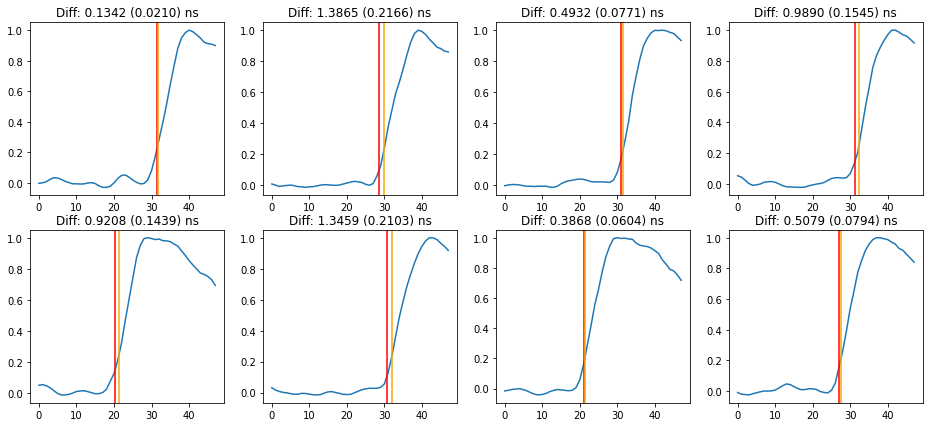

In [12]:
plt.figure(figsize=(16, 7))
plot_samples(X_test, y_test, y_pred)

In [13]:
y_pred.shape

(3914,)

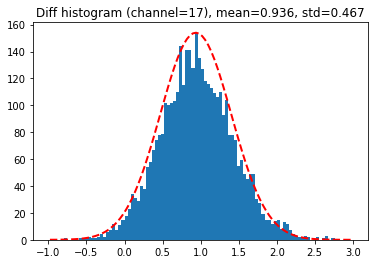

In [14]:
std_cfd = plot_difference_hist(y_test, y_pred, 17, hist_range=(-1, 3))

# Model 1

In [15]:
model = keras.Sequential([
    layers.Input(48),
    layers.Dense(1)
])

history = train_model(model, lr=0.1, name='model_1', train=False, n_epochs=3000, lr_patience=50, es_patience=400)

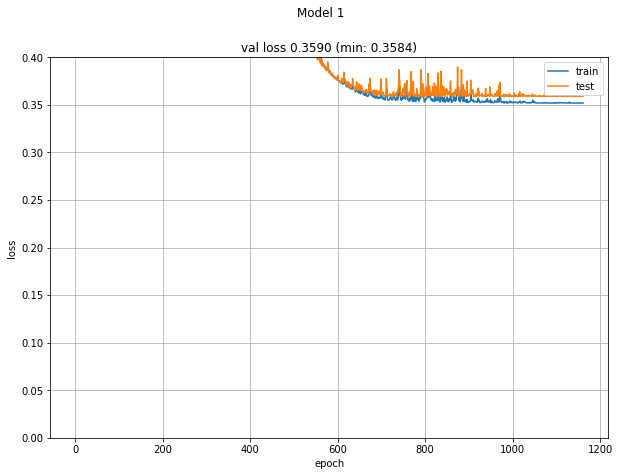

In [16]:
plot_history(history, "Model 1", ymax=0.4)

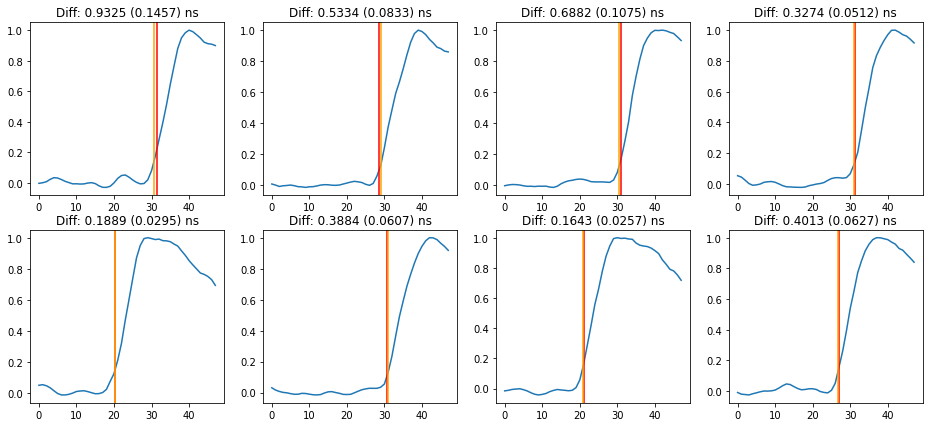

In [17]:
plt.figure(figsize=(16, 7))
y_pred = model.predict(X_test)[:, 0]
plot_samples(X_test, y_test, y_pred)

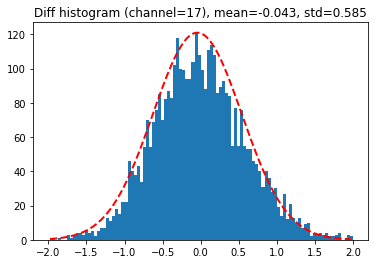

In [18]:
std_1 = plot_difference_hist(y_test, y_pred, 17)

# Model 2

In [19]:
model = keras.Sequential([
    layers.Input(48),
    
    layers.Dense(48, activation='relu'),
    layers.Dense(24, activation='relu'),
    layers.Dense(12, activation='relu'),
    layers.Dense(1)
])

history = train_model(model, lr=0.01, name='model_2', train=False, n_epochs=3000, lr_patience=50, es_patience=400)

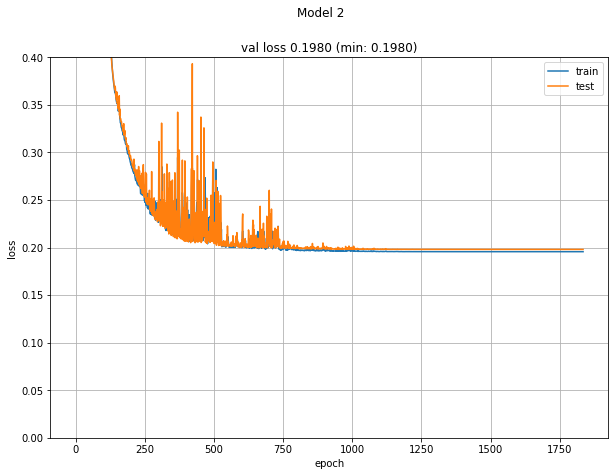

In [20]:
plot_history(history, "Model 2", ymax=0.4)

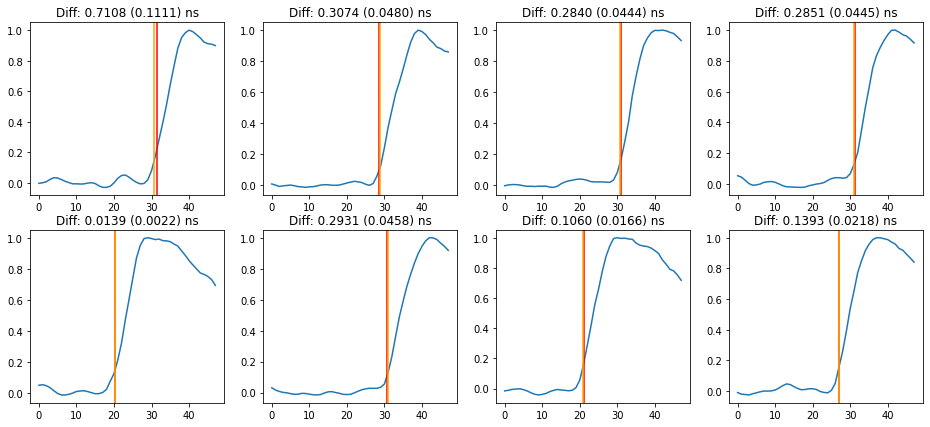

In [21]:
plt.figure(figsize=(16, 7))
y_pred = model.predict(X_test)[:, 0]
plot_samples(X_test, y_test, y_pred)

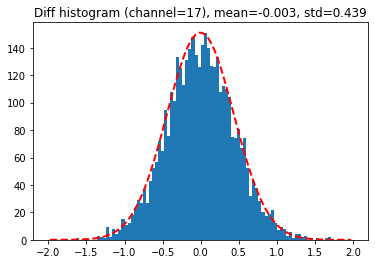

In [22]:
std_2 = plot_difference_hist(y_test, y_pred, 17)

# Model 3

In [23]:
model = keras.Sequential([
    layers.Input(48),
    layers.Dropout(0.2),
    
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(1)
])

history = train_model(model, lr=0.01, name='model_3', train=False, n_epochs=10000, lr_patience=50, es_patience=1000)

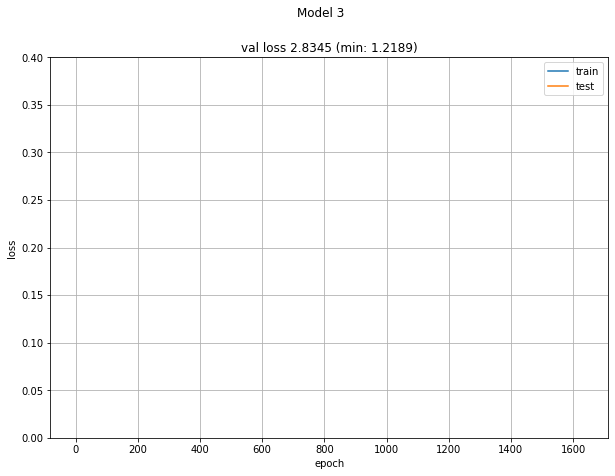

In [24]:
plot_history(history, "Model 3", ymax=0.4)

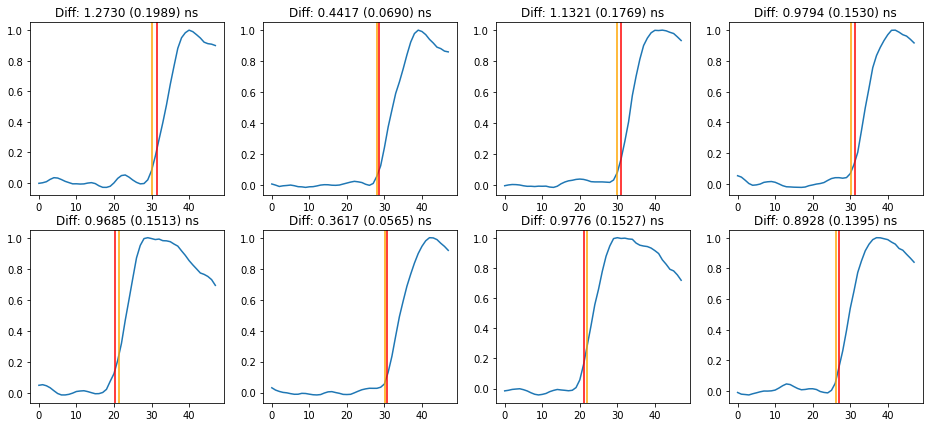

In [25]:
plt.figure(figsize=(16, 7))
y_pred = model.predict(X_test)[:, 0]
plot_samples(X_test, y_test, y_pred)

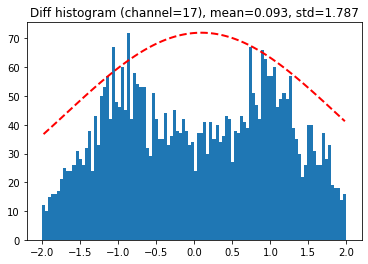

In [26]:
std_3 = plot_difference_hist(y_test, y_pred, 17)

# Model 4

In [27]:
model = keras.Sequential([
    layers.Input(48),
    layers.Reshape((-1, 1)),
    
    layers.Conv1D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling1D(2),
    
    layers.Conv1D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling1D(2),
    
    layers.Flatten(),
    layers.Dense(1)
])

history = train_model(model, lr=0.1, name='model_4', train=False, n_epochs=3000, lr_patience=50, es_patience=200)

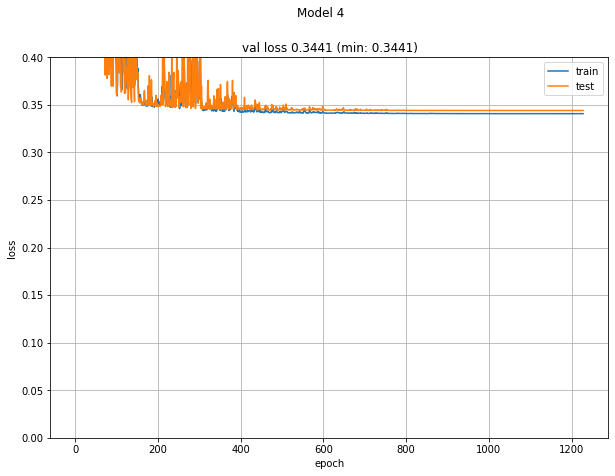

In [28]:
plot_history(history, "Model 4", ymax=0.4)

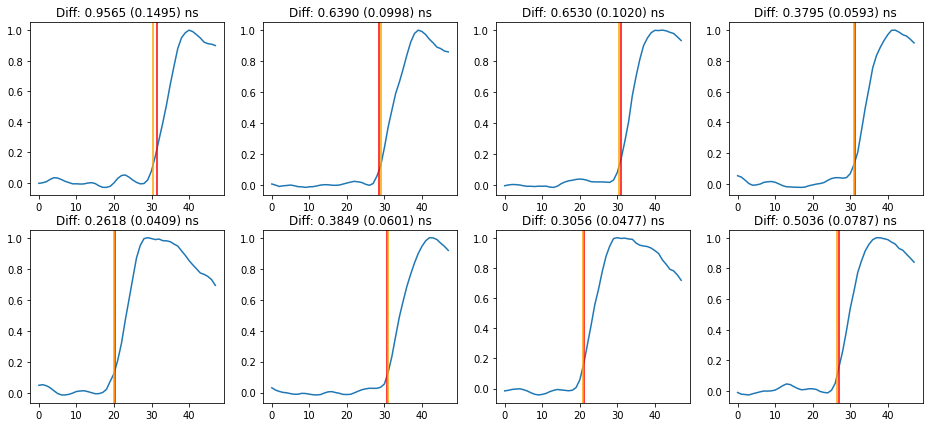

In [29]:
plt.figure(figsize=(16, 7))
y_pred = model.predict(X_test)[:, 0]
plot_samples(X_test, y_test, y_pred)

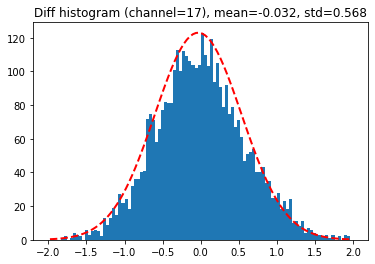

In [30]:
std_4 = plot_difference_hist(y_test, y_pred, 17)

# Model 5

In [31]:
model = keras.Sequential([
    layers.Input(48),
    layers.Reshape((-1, 1)),
    
    layers.Conv1D(32, 3, padding='same'),
    # layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv1D(32, 3, padding='same'),
    # layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling1D(2),
    
    layers.Conv1D(64, 3, padding='same'),
    # layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv1D(64, 3, padding='same'),
    # layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling1D(2),
    
    layers.Conv1D(128, 3, padding='same'),
    # layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv1D(128, 3, padding='same'),
    # layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling1D(2),
    
    layers.Flatten(),
    layers.Dense(1)
])

history = train_model(model, lr=0.001, name='model_5', train=False, n_epochs=3000, lr_patience=100, es_patience=500)
# model.summary()

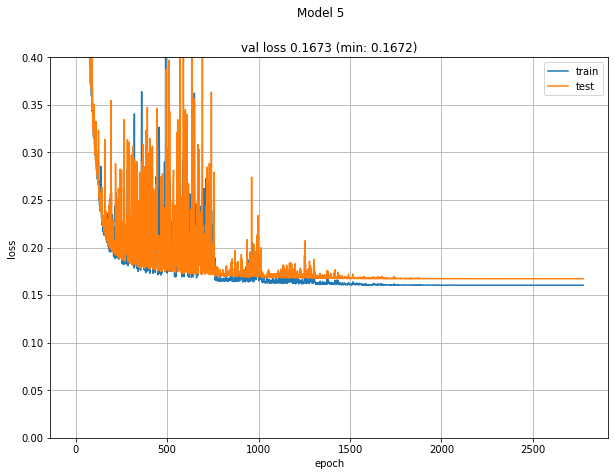

In [32]:
plot_history(history, "Model 5", ymax=0.4)

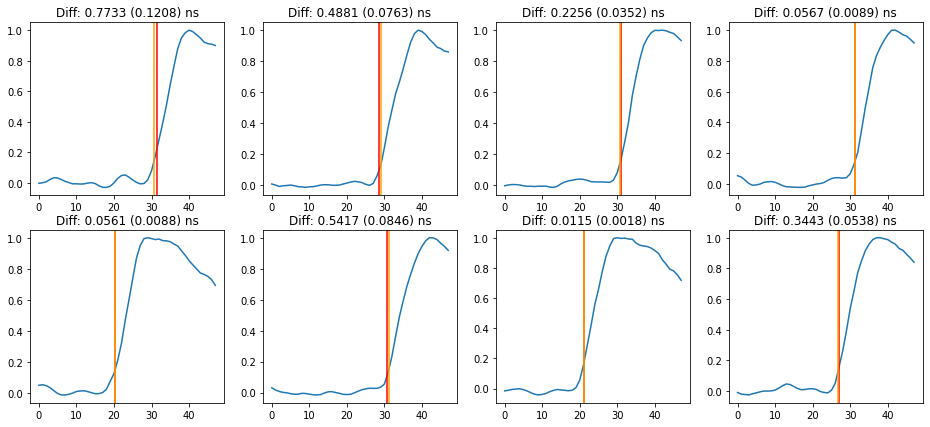

In [33]:
plt.figure(figsize=(16, 7))
y_pred = model.predict(X_test)[:, 0]
plot_samples(X_test, y_test, y_pred)

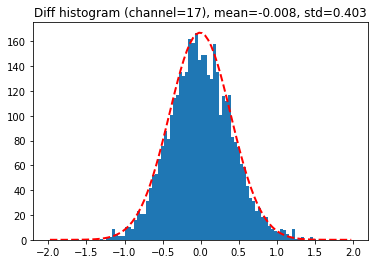

In [34]:
std_5 = plot_difference_hist(y_test, y_pred, 17)

# Model 6 (ResNet)

In [35]:
def residual_block(x, n_filters, strides=2):
    skip = layers.Conv1D(n_filters, 1, strides=strides)(x)
    
    x = layers.Conv1D(n_filters // 4, 1, strides=strides)(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv1D(n_filters // 4, 3, padding='same')(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv1D(n_filters, 1)(x)
    
    x = layers.Add()([skip, x])
    x = layers.ReLU()(x)
    
    return x

inputs = layers.Input(48)
x = layers.Reshape((-1, 1))(inputs)

x = residual_block(x, 32)
x = residual_block(x, 64)
x = residual_block(x, 128)
x = residual_block(x, 256)

# x = layers.Flatten()(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs)

#############################################

history = train_model(model, lr=0.001, name='model_6', train=False, n_epochs=5000, lr_patience=100, es_patience=400)
# model.summary()

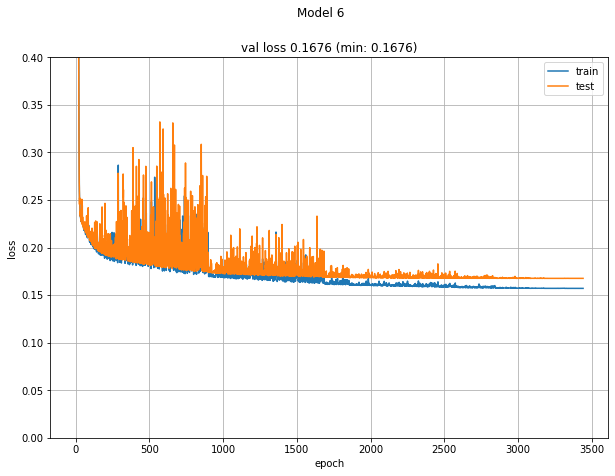

In [36]:
plot_history(history, "Model 6", ymax=0.4)

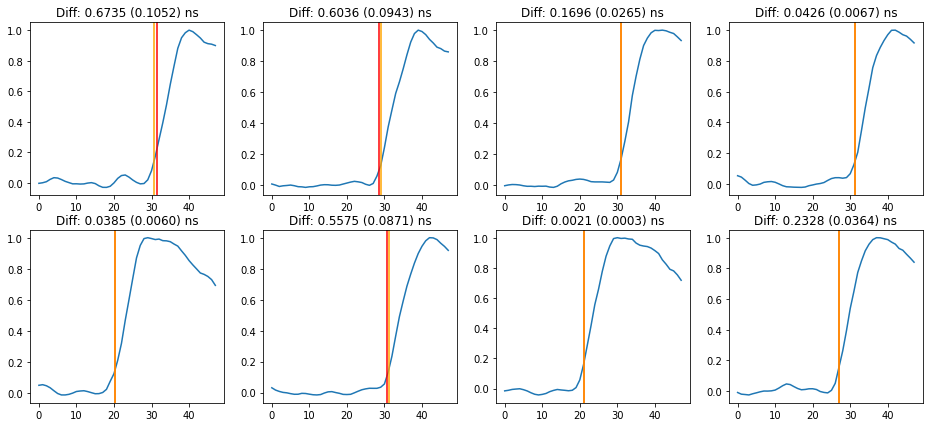

In [37]:
plt.figure(figsize=(16, 7))
y_pred = model.predict(X_test)[:, 0]
plot_samples(X_test, y_test, y_pred)

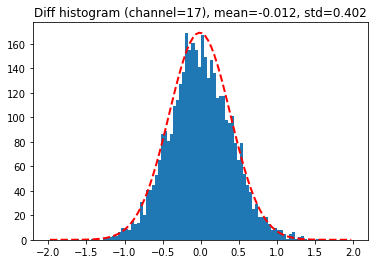

In [38]:
std_6 = plot_difference_hist(y_test, y_pred, 17)

# Model 7 (UNet)

In [39]:
def gaussian_kernel(mu, sigma=0.8, n=48):
    x = np.arange(0, n)
    return np.exp(-(x - mu)**2 / (2 * sigma**2))

_get_gauss_stats(gaussian_kernel(np.array(1.6)))

1.6

In [40]:
Y_heatmap_train = np.array([gaussian_kernel(y) for y in y_train])
Y_heatmap_test = np.array([gaussian_kernel(y) for y in y_test])

In [41]:
def conv_block(x, n_filters):
    x = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    skip = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    # skip = residual_block(x, n_filters, strides=1)
    x = layers.MaxPooling1D()(skip)
    return skip, x
    
def deconv_block(x, skip, n_filters):
    x = layers.UpSampling1D()(x)
    x = layers.Conv1D(n_filters, 1, activation='linear')(x)
    x = layers.Concatenate()([skip, x])
    x = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    x = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    # x = residual_block(x, n_filters, strides=1)
    return x
    
    
###################################

inputs = layers.Input(48)
x = layers.Reshape((-1, 1))(inputs)

skip1, x = conv_block(x, 8)
skip2, x = conv_block(x, 16)
skip3, x = conv_block(x, 32)
x, _ = conv_block(x, 64)

x = deconv_block(x, skip3, 32)
x = deconv_block(x, skip2, 16)
x = deconv_block(x, skip1, 8)

x = layers.Conv1D(1, 1, activation='linear')(x)

outputs = layers.Flatten()(x)

model = tf.keras.Model(inputs, outputs)

#############################################

history = train_model(model, y_train=Y_heatmap_train, y_test=Y_heatmap_test, lr=0.0005, name='model_7', train=False, n_epochs=2000, lr_patience=50, es_patience=200, loss_weights=100)
# model.summary()

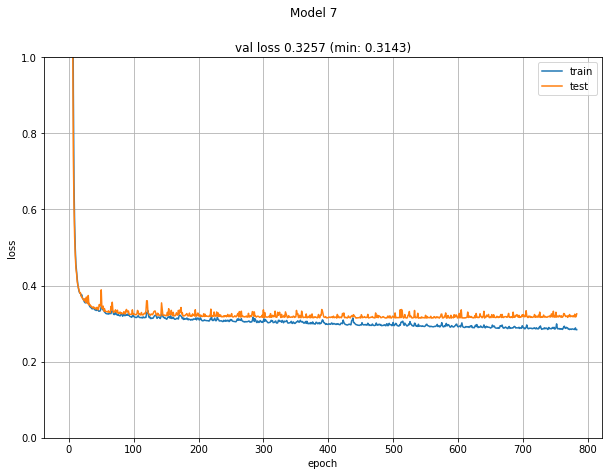

In [42]:
plot_history(history, "Model 7", ymax=1)

C:\Users\MatiX\anaconda3\envs\py310\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)
C:\Users\MatiX\anaconda3\envs\py310\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


0.16274976987225262

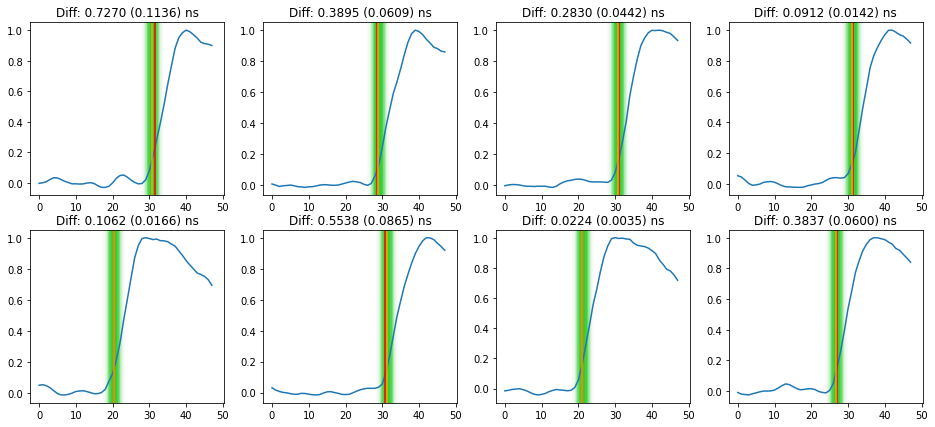

In [43]:
plt.figure(figsize=(16, 7))
Y_heatmap_pred = model.predict(X_test)

y_pred = np.empty(Y_heatmap_pred.shape[0])
for i, y in enumerate(Y_heatmap_pred):
    y_pred[i] = _get_gauss_stats(y)
    
plot_samples(X_test, y_test, y_pred, Y_heatmap=Y_heatmap_pred)
mean_squared_error(y_test, y_pred)

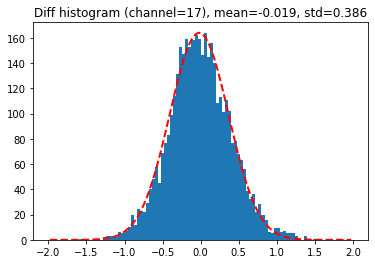

In [44]:
std_7 = plot_difference_hist(y_test, y_pred, 17)

# Compare standard deviations

In [45]:
print(f"{'CFD':>10}: {std_cfd:0.4f}")
for i, std in enumerate([std_1, std_2, std_3, std_4, std_5, std_6, std_7]):
    print(f"{f'model_{i+1}':>10}: {std:0.4f} samples; {std * TIME_STEP:0.4f} ns")

       CFD: 0.4666
   model_1: 0.5848 samples; 0.0914 ns
   model_2: 0.4390 samples; 0.0686 ns
   model_3: 1.7870 samples; 0.2792 ns
   model_4: 0.5684 samples; 0.0888 ns
   model_5: 0.4027 samples; 0.0629 ns
   model_6: 0.4020 samples; 0.0628 ns
   model_7: 0.3861 samples; 0.0603 ns
